# Activity 5.2. Autoencoder
In this activity we use H2O library to study the behavior of some deep autoencoder networks (For H2O instalation and configuration, please refer to Appendix 5.B). We apply these encouders on the MINST datasets which is a well-known collection of handwritten digits. We also compare their performance for dimension reduction with PCA. In Assignment 3, you will be asked to develop a self-taught network using the autoencoder we study here.

(*Note: Some parts of this activty are borrowed from http://www.r-bloggers.com/a-little-h2o-deeplearning-experiment-on-the-mnist-data-set/ *)

## MINST Dataset
MINST is a large dataset of handwritten digits that can be downloded from: https://www.kaggle.com/c/digit-recognizer/data?train.csv. The train set contatins 42K images each of them of size 28 by 28 pixels. Each row of the `train.csv` file represents one of the vectorized images as well as its label. Tehrefore, the dataset has 785 columns = 1 + 28 X 28. Here, we use a subset of images (only ditigits 0 to 3) that are stored in `train_0_3.csv`.

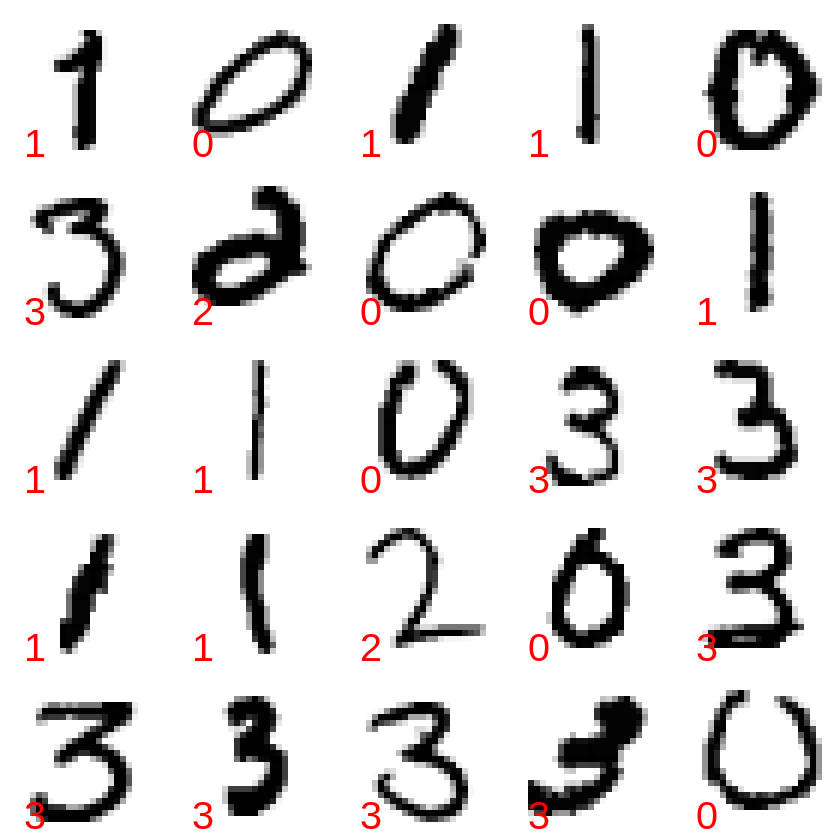

In [1]:
# read data
data = read.csv('./train_0_3_small.csv')

# visualize some samples
par( mfrow = c(5,5), mai = c(0,0,0,0))  # create a 5X5 grid to display values and update the margins
for(i in 1:25){
  y = as.matrix(data[i, 2:785])  # a matrix of the data using all columns but only y from 1:25 (starts at 2)
  dim(y) = c(28, 28)  # the dimensions of y are updated to be 28x28 so the pixels become dense and form numbers
  image(y[,nrow(y):1], axes = FALSE, col = gray(255:0 / 255))  # create an image based on the data values 
  text(0.2, 0, data[i,1], cex = 3, col = 2, pos = c(3,4))  # update the actual text for the real number
}

rm(list=ls()) # Clean up unnecessary variables.

## Initialzation
OK! Let's continue with loading H2O library, initiating our local H2O and importing the traininf datasets. 
For more information about these steps, please refer to **Appendix: H2O Library**.

**Note:** If your machine is not powerful enough, you may use `train_0_3_small.csv` instead of `train_0_3.csv` which has only `1000` images. However, this few number of images might not be enough to train a deep autoencoder.

In [ ]:
# Installing H2O
if ("package:h2o" %in% search()) { detach("package:h2o", unload=TRUE) }
if ("h2o" %in% rownames(installed.packages())) { remove.packages("h2o") }

# Next, we download packages that H2O depends on.
pkgs <- c("RCurl","jsonlite")
for (pkg in pkgs) {
if (! (pkg %in% rownames(installed.packages()))) { install.packages(pkg) }
}

# Now we download, install and initialize the H2O package for R.
install.packages("h2o", type="source", repos="http://h2o-release.s3.amazonaws.com/h2o/rel-yau/2/R")

In [3]:
# let's load H2O and start up an H2O cluster
options(warn=-1)
library(h2o)
h2o.init()
# If there is a proxy: 
## proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 hours 39 minutes 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.2 
    H2O cluster version age:    2 days  
    H2O cluster name:           root 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.38 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.5.1 (2018-07-02) 



In [5]:
# use absolute address or relative to the start location of the H2O instance!
train.file <- '/home/fit5201/train_0_3_small.csv'
train.frame <- h2o.importFile(path = train.file,sep=',') 
train.label <- as.character(as.vector(train.frame[,1]))

  |======================================================================| 100%


## Autoencoder
From the previous chapter, recall that an autoencoder is a neural network that maps input data points to lower dimension spaces, then tries to reconstruct them from those low dimensional feature vectors. In this activity, we train three autoencoders with different depths (number of hidden layers). To study their performances, we visualize the feature vectors from the middle hidden layer (which we deliberately choose to have only two units) and compare them with the first two principal components that we obtained by running a simple PCA.

To train a deep autoencoder, we call `h2o.deeplearning` function while specifying the number of units in each layer using `hidden` argument. For example, `hidden = c(100, 2, 100)` means we intend to build an autoencoder with three hidden layers where the first and the last one have `100` units and the middle one has only `2` units. Let's build our three autoencoders.

In [6]:
## Here we build some models. Take note with H2O each value in hidden doesn't include the input or output layers. 
## So c(100,2,100) means create a model with 1 input layer, 3 hidden layers and 1 output layer (i.e. 5 layers in total). 
## The number of nodes in the hidden layer is represented by the numbers so in this case 100, 2, and 100.
NN.model.1 = h2o.deeplearning(    
    x = 2:785, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(100, 2, 100), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE   # is it an autoencoder? Yes!
)

NN.model.2 = h2o.deeplearning(    
    x = 2:785, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(400, 100, 2, 100, 400), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE   # is it an autoencoder? Yes!
)

NN.model.3 = h2o.deeplearning(    
    x = 2:785, # select all pixels
    training_frame = train.frame, # specify the frame (imported file)    
    hidden = c(500,300,100,2,100,300,500), # number of layers and their units
    epochs = 100, # maximum number of epoches  
    activation = 'Tanh', # activation function 
    autoencoder = TRUE   # is it an autoencoder? Yes!
)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Now, our models are built and saved in `NN.model` variables. As mentioned before, we want to visualize the middle hidden layer, which for all the model we chose to have only two units. The `h2o.deepfeatures` function helps us to get access to these values. Note that the index of the middle layer varies in each model (as they have a different number of layers).

In [7]:
## The deepfeatures function returns the features from a specified layer from a model and returns an H2O frame object.
## The format of the function is deepfeatures(object, data, layer) where object is the model that was built, the data
## is the h20.frame that was used to build the model and the layer is the layer you want to extract features from.
## In this case, we're looking for the middle layer which is the one with 2 nodes in every model. 
## The position changes each time so the layer being extracted also changes.

project.1 = as.matrix(h2o.deepfeatures(NN.model.1, train.frame, layer=2)) ## layer 2 because c(100,2,100) - 2 is the second
project.2 = as.matrix(h2o.deepfeatures(NN.model.2, train.frame, layer=3))
project.3 = as.matrix(h2o.deepfeatures(NN.model.3, train.frame, layer=4))

# Environment clean-up. The models get big and they've already been saved
rm(NN.model.1, NN.model.2, NN.model.3)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


OK! Let's calculate the first two principle components and then plot all the projections in one frame.

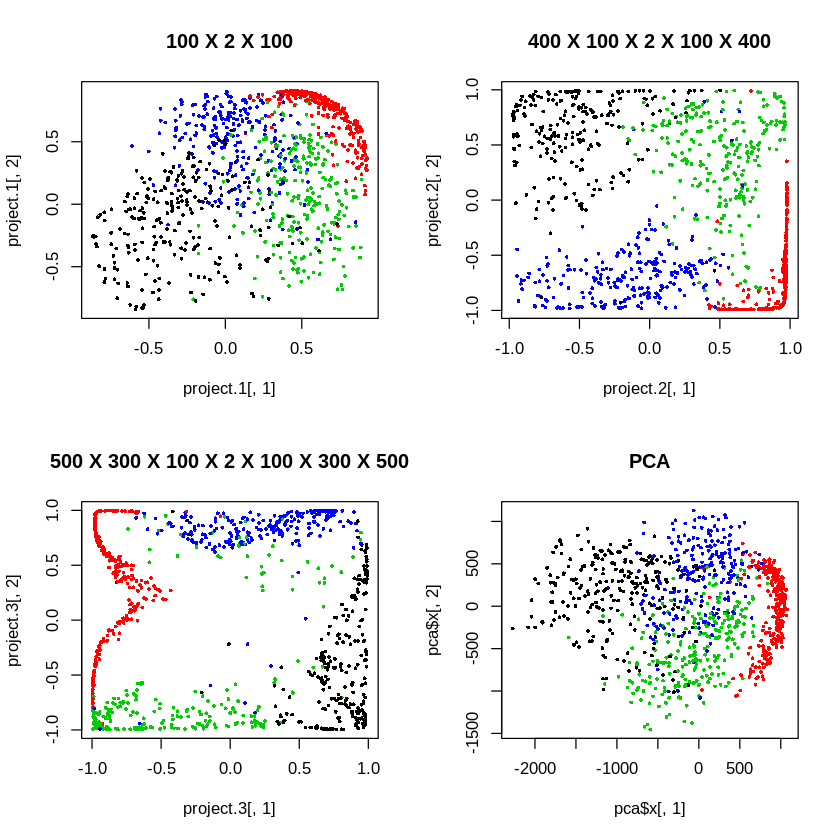

In [8]:
data <- read.csv(train.file)
pca  <- prcomp(data[,-1])  # run the pca
par(mfrow=c(2,2))  # update graphical settings to have 2 x 2 grid for plots

plot(project.1[,1], project.1[,2], col=data[,1]+1, pch=16, cex=0.5, main='100 X 2 X 100') ## The labels are the hidden layer dimensions
plot(project.2[,1], project.2[,2], col=data[,1]+1, pch=16, cex=0.5, main='400 X 100 X 2 X 100 X 400')
plot(project.3[,1], project.3[,2], col=data[,1]+1, pch=16, cex=0.5, main='500 X 300 X 100 X 2 X 100 X 300 X 500')
plot(pca$x[,1], pca$x[,2], col=data[,1]+1, pch=16, cex=0.5, main='PCA')

## Discussions
1- Does increasing the numebr of layers help us creating more discreminative features? 

2- In general, how the number of hidden layers (i.e., the depth of the autoencoder) affects the performance of the network (in terms of recunstruction accuracy and time complexity)?

3- In typical problems, what factors prevent us from building very deep networks (with hundreds of layers)?